# Introduction

The analysis is carried out in [scanpy](https://github.com/theislab/scanpy), a fantastic open-source single-cell Python package.

There is a number of supportive packages we have to import, most importantly `anndata`, a matrix-based data structure, which can be used to store transcript counts per cell per gene.

Anndata supports multiple layers of the count matrix, which can be used to store counts of both mature, spliced mRNA molecules, and nascent, unspliced ones. Layers make it possible to use scanpy in analysing not only the position of individual cells, but also the direction of their development, dubbed "RNA velocity". This is achieved with the `scvelo` package.

In [1]:
import numpy as np
import pandas
import scanpy as sc
import anndata
import json
import matplotlib.pyplot as plt
import scvelo as scv
import os
%matplotlib inline

/home/picrin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Loading the loom file

We've already carried out alignement, barcode correction, some initial filtering, and spliced and unspliced transcript counting, using respectively the `STAR` aligner, `dropest` barcode correction and `velocyto` to produce the loom file (we do not use its computed velocity field). We can load the loom file into an `anndata` object using scanpy.

In [2]:
adata = sc.read_loom("correct_result_9QWIF.loom")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


It's a good idea to poke around a little bit and check out our data before we analyse it.

In [3]:
adata

AnnData object with n_obs × n_vars = 2104 × 58395 
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

Let's note that `n_obs` is the number of individual cancer cells -- after barcode correction and initial quality filtering. `n_vars` is the number of detected genes. Both dimensions will be reduced by further quality checks.

Let's check out the layers

In [4]:
adata.layers.as_dict()

{'ambiguous': <2104x58395 sparse matrix of type '<class 'numpy.float32'>'
 	with 639413 stored elements in Compressed Sparse Row format>,
 'matrix': <2104x58395 sparse matrix of type '<class 'numpy.float32'>'
 	with 4690195 stored elements in Compressed Sparse Row format>,
 'spliced': <2104x58395 sparse matrix of type '<class 'numpy.float32'>'
 	with 3676753 stored elements in Compressed Sparse Row format>,
 'unspliced': <2104x58395 sparse matrix of type '<class 'numpy.float32'>'
 	with 1076388 stored elements in Compressed Sparse Row format>}

As we can see, there are multiple matrices stored in the `anndata` object. `spliced` and `unspliced` are the ones we'll be interested in for the velocity computation.

Layers are only used for RNA velocity. Other types of analysis are carried using, just a single matrix, stored as a field in the `anndata` object, e.g. `adata.X`

In [5]:
type(adata.X)

scipy.sparse.csr.csr_matrix

As we can see, this is identical to the "spliced" matrix from the layers. This makes sense as mature (spliced) mRNA should be most abundant in since most experimental techniques (including our technique, Drop-seq) enrich for the polyA cap using a polyT cDNA sequence present at the end of the bead used to capture RNA.

In [6]:
np.allclose(adata.X.toarray(), adata.layers.as_dict()["spliced"].toarray())

True

We can inspect the column (gene) information. Accession is a unique, immutable gene identifier, which tends to be more machine-friendly than still evolving gene nomenclature (e.g. CELF1 is sometimes referred to as CUGBP1). Chromosome, End, Start and Strand uniquely identify the position of the gene in a reference human chromosome (we use GRCh38).

In [7]:
adata.var[:10]

,Accession,Chromosome,End,Start,Strand
WASH7P,ENSG00000227232,1,29570,14404,-
MIR6859-1,ENSG00000278267,1,17436,17369,-
FAM138A,ENSG00000237613,1,36081,34554,-
AL627309.1,ENSG00000238009,1,133723,89295,-
AL627309.3,ENSG00000239945,1,91105,89551,-
AL627309.6,ENSG00000268903,1,135895,135141,-
AL627309.7,ENSG00000269981,1,137965,137682,-
AL627309.2,ENSG00000239906,1,140339,139790,-
AL627309.5,ENSG00000241860,1,173862,141474,-
RNU6-1100P,ENSG00000222623,1,157887,157784,-


In [8]:
"CUGBP1" in adata.var_names

False

In [9]:
"CELF1" in adata.var_names

True

row (cell) information is less interesting, since at the beginning of the analysis we know very little about any particular cell -- the only information we have is the cellular barcode. In fact, the whole analysis can be viewed as transferring existing information we have about genes to information about cells, all done via the count matrices.

In [10]:
adata.obs[:10]

""
correct_result_9QWIF:AATCCTACATATx
correct_result_9QWIF:AAATGTAAGACTx
correct_result_9QWIF:AAGCAGGTGCTTx
correct_result_9QWIF:AAACACCAGCATx
correct_result_9QWIF:AAGCTCATGCGGx
correct_result_9QWIF:AAGTGATTGGAGx
correct_result_9QWIF:AATCGCTGTTTTx
correct_result_9QWIF:AACGGGTTCGTGx
correct_result_9QWIF:AACCTCTCTTCTx
correct_result_9QWIF:AAGCAAGTAACTx


# Filtering and normalisation

First, let's make all gene names unique

In [11]:
old_names = set(adata.var_names)

In [12]:
adata.var_names_make_unique()

In [13]:
new_names = set(adata.var_names)

Inspection of gene names suggests that most genes requiring disambiguation are small non-coding RNAs.

In [14]:
list(new_names - old_names)[:10]

['RF00561-3',
 'RF00012-47',
 'RF00019-614',
 'RF00019-572',
 'RF00322-13',
 'RF00090-2',
 'RF00017-152',
 'RF00443-1',
 'RF00019-131',
 'RF00026-19']

In [15]:
len(new_names - old_names)

1543

The first thing we can learn about cancer cells in our dataset is the total count of RNA moleclues (often referred to as UMI)

In [16]:
UMI_count = adata.X.sum(1)

In [17]:
UMI_count

matrix([[ 1474.],
        [ 3058.],
        [16258.],
        ...,
        [ 2949.],
        [ 1871.],
        [ 1710.]], dtype=float32)

In [18]:
UMI_count.shape

(2104, 1)

In [19]:
counts = np.ravel(UMI_count)
counts.shape

(2104,)

In [20]:
adata.obs["n_counts"] = counts

We can visualise our newly computed information about cells using a violin plot

... storing 'Chromosome' as categorical
... storing 'Strand' as categorical


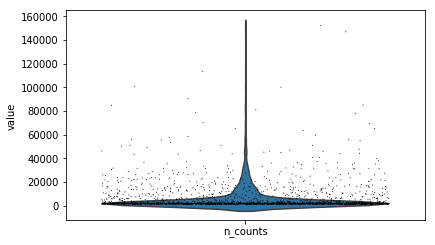

In [21]:
sc.pl.violin(adata, ['n_counts'], jitter=0.4)

Very highly expressed cells are likely doublets or triplets or some other types of artifacts. We can filter out, say 5% of most expressed cells.

In [22]:
cutoff = sorted(counts)[int(len(counts)*0.95)]

In [23]:
adata = adata[adata.obs['n_counts'] < cutoff, :]

We can visualise our data again

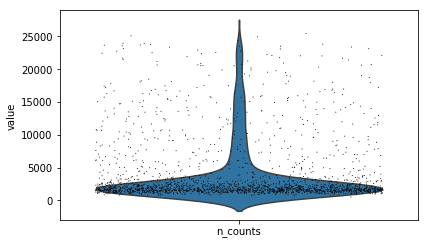

In [24]:
sc.pl.violin(adata, ['n_counts'], jitter=0.4)

Lowly expressed cells are also a concern -- these can indicate ruptured or apoptotic cell remnants. Earlier stages of the pipeline have already filtered some of these cells, but we should still be cautions.

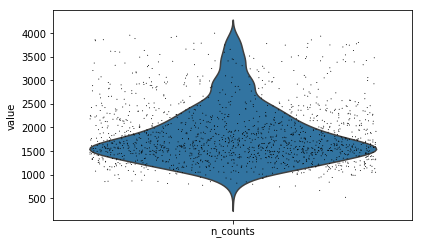

In [25]:
sc.pl.violin(adata[adata.obs["n_counts"] < 4000, : ], ['n_counts'], jitter=0.4)

As we can see, very few cells are expressed at a level of 1000 UMI or below. Given that these cells are most likely low quality/ ruptured/ apoptotic we can filter them out.

In [26]:
adata = adata[adata.obs["n_counts"] > 1000, :]

In [27]:
adata.shape

(1963, 58395)

We can also look at most highly expressed genes.

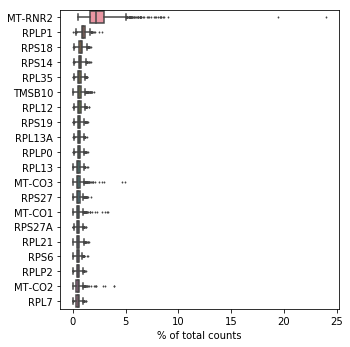

In [28]:
sc.pl.highest_expr_genes(adata, n_top=20)

As we can see, the list contains a lot of mitochondrial genes ("MT-"). This can be a cause of concern, as this can be indicative of a high proportion of ruptured cells. Previous studies using healthy tissue have filtered out cells with more than 5% mitochondrial RNA.

Let's first identify mitochondrial genes

In [29]:
mito_genes = adata.var_names.str.startswith('MT-')

And compute their percentage

In [30]:
adata.obs["percent_mito"] = np.ravel(np.sum(adata[:, mito_genes].X, axis=1)) / adata.obs["n_counts"]

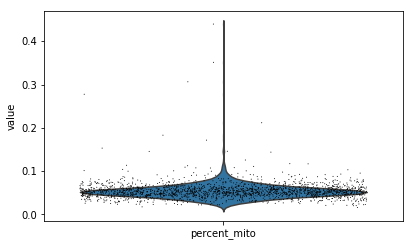

In [31]:
sc.pl.violin(adata, ['percent_mito'], jitter=0.4)

As can be seen in the plot, rejecting all cells with more than 5% mitochondrial RNA would significantly reduce our sample. However, given that these are cancer cells, and mitochondrial function is [known to be dirupted](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4371788/) in cancer, we will adjust the usual threshold to 10%.

In [32]:
adata = adata[adata.obs['percent_mito'] < 0.1, :]

In [33]:
adata

View of AnnData object with n_obs × n_vars = 1937 × 58395 
    obs: 'n_counts', 'percent_mito'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

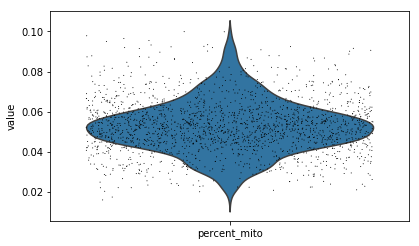

In [34]:
sc.pl.violin(adata, ['percent_mito'], jitter=0.4)

Next, we can filter out cells which express few genes, and filter out genes which are present in only small number of cells. We will save the original list of genes separately to allow for investigation even after reduction of the number of genes.

In [35]:
sc.pp.filter_cells(adata, min_genes=200)
genes_accessions = adata.var["Accession"]
adata.uns['before_filter_rare_genes'] = list(genes_accessions.index), list(genes_accessions)
sc.pp.filter_genes(adata, min_cells=100)

These filters compute an addition observation, `n_genes` (and an additional column `n_columns`). This is all that we've managed to learn about our cells so far.

In [36]:
adata.obs[:10]

,n_counts,percent_mito,n_genes
correct_result_9QWIF:AATCCTACATATx,1474.0,0.046133,869
correct_result_9QWIF:AAATGTAAGACTx,3058.0,0.045782,1513
correct_result_9QWIF:AAGCAGGTGCTTx,16258.0,0.033583,4058
correct_result_9QWIF:AAACACCAGCATx,16410.0,0.096527,4251
correct_result_9QWIF:AAGCTCATGCGGx,3250.0,0.092615,1580
correct_result_9QWIF:AAGTGATTGGAGx,1566.0,0.047254,908
correct_result_9QWIF:AATCGCTGTTTTx,1347.0,0.069785,840
correct_result_9QWIF:AACGGGTTCGTGx,6427.0,0.055236,2458
correct_result_9QWIF:AAGCAAGTAACTx,1050.0,0.060952,695
correct_result_9QWIF:AATCAGGTATGTx,18164.0,0.047236,4708


Despite all the filtering, a number of gene counts is still a major source of variation, and given that the origin of this variation is believed to be mostly technical, and biologically uninteresting, we will attempt to remove it by rescaling total gene count in each cell to 10000

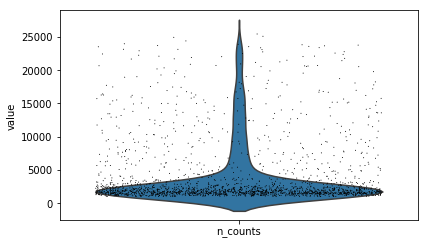

In [37]:
sc.pl.violin(adata, ['n_counts'], jitter=0.4)

In [38]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

Prior experience working with microarray and bulk RNA-seq data suggests that many effects are linear in the logarithm of the UMI count (or probe intensity, or read coverage), and it's therefore advised to log the data as part of the normalisation process.

In [39]:
sc.pp.log1p(adata)

In [40]:
genes_accessions = adata.var["Accession"]
adata.uns['before_filter_nonvariable_genes'] = list(genes_accessions.index), list(genes_accessions)

One method to reduce dimensionality, employed also by Seurat and CellRanger software, computes dispersion, which is the ratio of variance and mean of (logged) genes across all cells. Highly variable genes can be identified based on this parameter, and selected for further analysis. Additionally, highly expressed genes are unlikely to be helpful in the analysis, as they most likely come from non-coding RNA, and we can also filter them out.

In [41]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

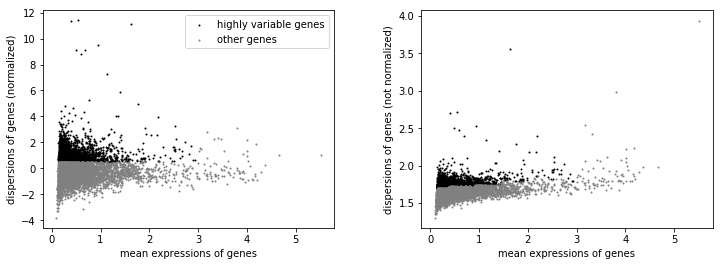

In [42]:
sc.pl.highly_variable_genes(adata)

In [43]:
adata = adata[:, adata.var['highly_variable']]

Gene variance on its own can be a source of unwanted signal in the data. All genes are scaled to unit variance and values exceeding std=10 can be clipped to extremes.

In [44]:
sc.pp.scale(adata, max_value=10)

# Write to file

In [45]:
try:
    os.mkdir("write")
except FileExistsError:
    pass

In [46]:
filepath = "./write/01_bile_duct_cancer.h5ad"

In [47]:
adata.write(filepath)

In [48]:
adasd

NameError: name 'adasd' is not defined

In [ ]:
adata = anndata.read(filepath)

In [ ]:
adata.X.shape

In [ ]:
adata.uns['before_filter_rare_genes'].shape

In [ ]:
adata.uns['before_filter_nonvariable_genes'].shape

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

We can make a scatter plot in the PCA coordinates, but we will not use that later on.

In [ ]:
import random

In [ ]:
#random.randint(len()

In [ ]:
liver_specific = """CD45
CD24
CD133
CD13
CD90/Thy1
Aminopeptidase N/CD13
SOX2
Nanog
SALL4""".split("\n")

In [ ]:
liver_specific

In [ ]:
#post_filtered_genes = set(adata.var.values.T[0])

In [ ]:
#for g in liver_specific:
#    print(g, g in gene_names)

In [ ]:
#len(gene_names)

In [ ]:
#with open("gene_names", "w") as f:
#    for gene in gene_names:
#        f.write(gene)
#        f.write("\n")

In [ ]:
#for g in liver_specific:
#    print(g in post_filtered_genes)

Hi guys, as I mentioned earlier I started looking at this at a slightly different angle. Instead of looking at velocity first, and then trying to look at expression of stemness biomarkers, I'm trying to look at stemness biomarkers first. I'm doing the analysis using a completely different package, called "scanpy".

I'm still looking only at this single cell line (CRB), as I ran into some problems trying to compute count matrices in another cell line, but I should be able to fix those later.

The plots look slightly different, I suspect this is because there are slight differences between how scanpy and how velocyto normalise the data.

I've looked at a full list of liver cancer stemness biomarkers, and most of them are not expressed/ get filtered out/ I have some discrepancies in gene names and I can't identify correct genes. But one cancer stemness biomarker, CD24 is actually present in big quantities in some of our cells, but absent in other cells. By big differences I mean 2-3 orders of magnitude (before logging).

Possibly these cells are cancer stem cells. This could be confirmed in two ways:

Confirmation 1. Using Louvain community detection, detecting a cluster corresponding to stem cells, doing differential expression of genes in the cluster vs other clusters, and detecting a higher expression of "progenitor" genes. There are still some problems with the analysis, but I think I should be able to get such cluster. I'll need some help to interpret the results -- could you guys get me in touch with your cancer biologists?

Confirmation 2. Looking at the velocity field directly, and seeing that those cells are at the source of the velocity flow.

So how does a PCA with "CD24" coloured looks like? Well, it looks like this:

I suspect the cluster in the middle might actually be some sort of visual artifact, there's a very high density of points close to (0, 0) of the graph, and if there's a lot of points there, some of them will have high concentrations of "CD24", which makes the whole area stand out. I suspect the cluster lying on the outskirts is much more interesting.

Re confirmation 1: how do the Louvain communities look like on a UMAP (it's like tSNE, but faster) cluster? Well, they look like this:

It looks like cluster 2 corresponds to our candidate "stem cells". How does it differ from other clusters in terms of gene expression? Well, it seems that genes that differ are: [SOX4, EEF1A1, RPL34, NEAT1, KRT8, RPL21, EML4]. Now, the plot is slightly weird, I would expect p-values and what I'm seeing are some sort of ranks, I'll have to chew over this to work out what exactly is going on.

Anyway, this is what I'm standing on right now.

In [ ]:
sc.pl.pca(adata, color='n_counts')

In [ ]:
sc.pl.pca(adata, color='CD24')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine.

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result.

In [ ]:
adata.write(results_file)

In [ ]:
adata

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

## Embedding the neighborhood graph

We advertise embedding the graph in 2 dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is  potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preservers trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')
```

In [ ]:
sc.tl.umap(adata)

In [ ]:
"TGFB1" in adata.var_names

In [ ]:
sc.pl.umap(adata, color=["CD24"])

As we set the `.raw` attribute of `adata`, the previous plots showed the "raw" (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

In [ ]:
sc.pl.umap(adata, color=['CD24'], use_raw=False)

## Clustering the neighborhood graph

As Seurat and many others, we recommend the Louvain graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by [Levine et al. (2015)](https://doi.org/10.1016/j.cell.2015.05.047). Note that Louvain clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [ ]:
sc.tl.louvain(adata)

Plot the clusters, which agree quite well with the result of Seurat.

In [ ]:
sc.pl.umap(adata, color=['louvain', 'CD24'])

Save the result.

In [ ]:
adata.write(results_file)

# Compute velocity

In [ ]:
scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata)

In [ ]:
scv.tl.velocity_embedding(adata, basis='umap')

In [ ]:
scv.tl.velocity_embedding(adata, basis='umap')
sc.pl.umap(adata, color=['louvain', 'CD24'])

In [ ]:
scv.pl.velocity_embedding_grid(adata, basis='umap', arrow_length=3, arrow_size=1.3)

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://de.wikipedia.org/wiki/Wilcoxon-Mann-Whitney-Test) test is very similar. We recommend using the latter in publications, see e.g., [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the result.

In [ ]:
adata.write(results_file)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by [Natranos et al. (2018)](https://doi.org/10.1101/258566). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. [Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79) has more details.

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

With the exceptions of *IL7R*, which is only found by the t-test and *FCER1A*, which is only found by the other two appraoches, all marker genes are recovered in all approaches.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes

Let us also define a list of marker genes for later reference.

In [ ]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',  
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [ ]:
adata = sc.read(results_file)

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

Get a table with the scores and groups.

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

Compare to a single cluster. 

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Reload the object that computed differential expression by comparing to the rest of the groups.

In [ ]:
adata = sc.read(results_file)

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

If you want to compare a certain gene across groups, use the following.

In [ ]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='louvain')

Actually mark the cell types.

In [ ]:
new_cluster_names = [
    'CD4 T', 'CD14+ Monocytes',
    'B', 'CD8 T', 
    'NK', 'FCGR3A+ Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('louvain', new_cluster_names)

In [ ]:
sc.pl.umap(adata, color='louvain', legend_loc='on data', title='', frameon=False, save='.pdf')

Now that we annotated the cell types, let us visualize the marker genes.

In [ ]:
ax = sc.pl.dotplot(adata, marker_genes, groupby='louvain')

There is also a very compact violin plot.

In [ ]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='louvain', rotation=90)

During the course of this analysis, the AnnData accumlated the following annotations.

In [ ]:
adata

In [ ]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations.

In [ ]:
adata.X = None
adata.write('./write/pbmc3k_withoutX.h5ad', compression='gzip')

If you want to export to "csv", you have the following options:

In [ ]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )